#### Master Thesis 2024 - Diksha Acharya
# 1- Data Cleaning of T° and RH 3h and daily

---
1.1 - Imports and tables


Imports

In [1]:
# Import 
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import os
from shapely.geometry import Point
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
# Indian states shapefile
shapefile_path = "Indian_States"
Indian_states = gpd.read_file(shapefile_path)

In [ ]:
# table for 2m temperature 3h
file_T_3h = "India_T_3h.nc"
T_3h = xr.open_dataset(file_T_3h)
T_3h['t2m']

<xarray.DataArray 't2m' (time: 245448, latitude: 124, longitude: 120)>
[3652266240 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1940-01-01 ... 2023-12-31T21:00:00
  * longitude  (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude   (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25
Attributes:
    long_name:  2 metre temperature
    units:      K

In [4]:
T_3h['t2m'].max() - 273.15

<xarray.DataArray 't2m' ()>
array(52.2678772)

In [7]:
T_3h['t2m'].min() - 273.15

<xarray.DataArray 't2m' ()>
array(-52.77805176)

In [5]:
# table for % relative humidity 
file_RH_3h = "India_RH_3h.nc"
RH_3h = xr.open_dataset(file_RH_3h)
RH_3h['r']

<xarray.DataArray 'r' (time: 245448, latitude: 124, longitude: 120)>
[3652266240 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1940-01-01 ... 2023-12-31T21:00:00
  * longitude  (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude   (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25
Attributes:
    standard_name:  relative_humidity
    long_name:      Relative humidity
    units:          %

In [6]:
RH_3h['r'].max() 

<xarray.DataArray 'r' ()>
array(207.24440002)

In [8]:
RH_3h['r'].min() 

<xarray.DataArray 'r' ()>
array(-24.7527771)

In [12]:
# Check how many values in the 'r' data array are greater than 100%
values_above_100 = (RH_3h['r'] > 100).sum()
values_above_100.values


array(54002144)

In [13]:
# Check how many values in the 'r' data array are greater than 100%
values_above_100 = (RH_3h['r'] < 0).sum()
values_above_100.values

array(17565)

---
1.2 - Mask to India

1.2.1 - Temperature

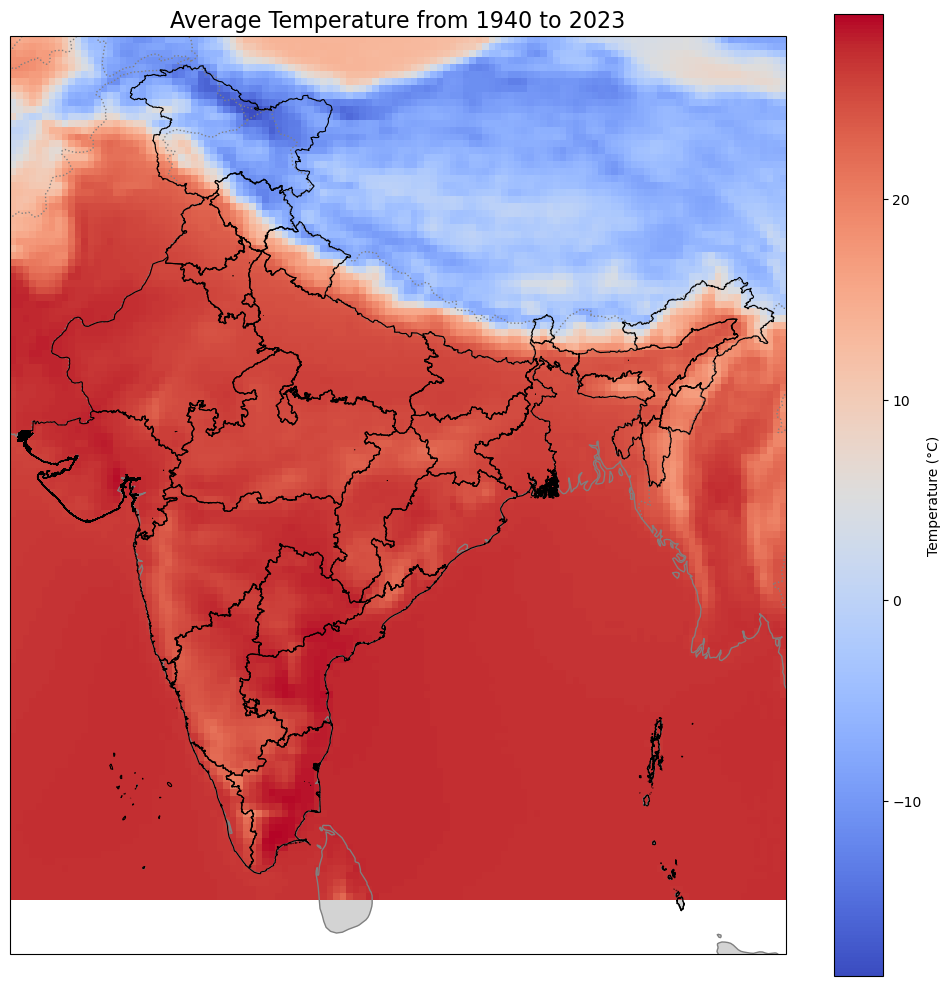

In [11]:
# Plotting the average temperature all on the map of India
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Add Indian states boundaries
Indian_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

# Plot the data
img = ax.pcolormesh(T_3h['longitude'], T_3h['latitude'], (T_3h['t2m']-273.15).sel(time=slice('1940-01-01', '2023-12-31')).mean(dim='time'), # year - month - day & mean of this period
                    cmap='coolwarm', transform=ccrs.PlateCarree())
cbar = plt.colorbar(img, ax=ax, label='Temperature (°C)')

# Title and labels
plt.title("Average Temperature from 1940 to 2023", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.tight_layout()
plt.show()

In [7]:
# Function to create a mask for India
def create_india_mask(lon, lat, shapefile):
    """
    Create a mask for India based on the shapefile.
    """
    # Create a grid of points from longitude and latitude
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    points = [Point(lon, lat) for lon, lat in zip(lon_grid.ravel(), lat_grid.ravel())]

    # Check if each point is within India
    mask = np.array([shapefile.contains(point).any() for point in points])
    mask = mask.reshape(lon_grid.shape)  # Reshape to match the grid
    return mask

# Get longitude and latitude from the dataset
lon = T_3h['longitude'].values
lat = T_3h['latitude'].values

# Create the India mask
india_mask = create_india_mask(lon, lat, Indian_states)

# Apply the mask to the dataset
T_masked = T_3h.copy()  # Create a copy of the dataset to avoid modifying the original
for var in T_masked.data_vars:  # Loop through all variables in the dataset
    # Broadcast the mask to match the shape of the variable (time, lat, lon)
    broadcasted_mask = np.broadcast_to(india_mask[np.newaxis, :, :], T_masked[var].shape)
    # Apply the mask
    T_masked[var].values = np.where(broadcasted_mask, T_masked[var].values, np.nan)

# Now T_masked contains only values within Indian states
print(T_masked)

<xarray.Dataset>
Dimensions:    (time: 245448, longitude: 120, latitude: 124)
Coordinates:
  * time       (time) datetime64[ns] 1940-01-01 ... 2023-12-31T21:00:00
  * longitude  (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude   (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25
Data variables:
    t2m        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Oct 16 17:32:30 2024: cdo -b F32 mergetime 1940_India_t...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...


In [19]:
T_masked_C = T_masked - 273.15

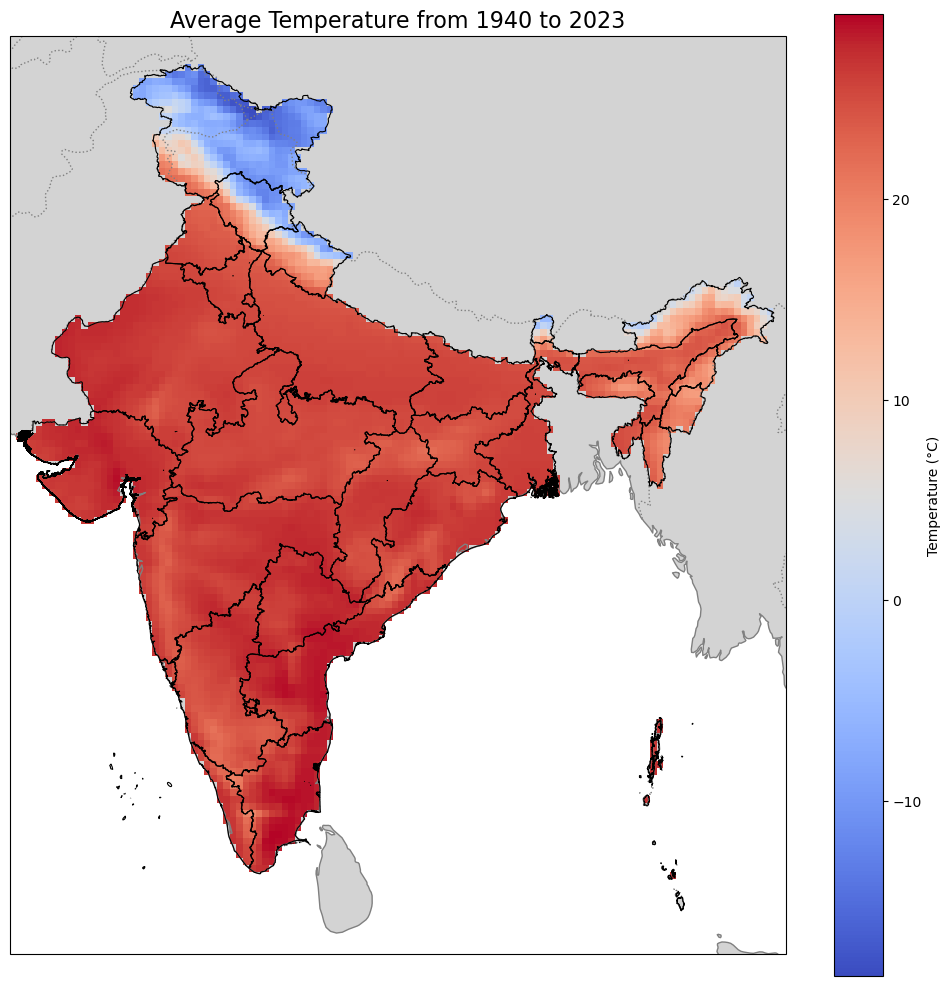

In [33]:
# Plotting the avergae temperature on the map of India
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Add Indian states boundaries
Indian_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

# Plot the data
img = ax.pcolormesh(T_masked_C['longitude'], T_masked_C['latitude'], T_masked_C['t2m'].sel(time=slice('1940-01-01', '2023-12-31')).mean(dim='time'), # year - month - day & mean of this period
                    cmap='coolwarm', transform=ccrs.PlateCarree())
cbar = plt.colorbar(img, ax=ax, label='Temperature (°C)')

# Title and labels
plt.title("Average Temperature from 1940 to 2023", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Save file
outputfile = "India_T_3h_masked_C.nc"
T_masked_C.to_netcdf(outputfile)

1.2.2 - Relative Humidity

In [ ]:
# Keeping only values between 0 and 100% for RH
RH_3h_100 = RH_3h.where((RH_3h['r'] > 0) & (RH_3h['r'] < 100))

In [14]:
RH_3h_100

<xarray.Dataset>
Dimensions:    (time: 245448, latitude: 124, longitude: 120)
Coordinates:
  * time       (time) datetime64[ns] 1940-01-01 ... 2023-12-31T21:00:00
  * longitude  (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude   (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25
Data variables:
    r          (time, latitude, longitude) float32 46.93 45.97 ... 85.81 82.52
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Oct 17 21:23:40 2024: cdo -b F32 mergetime 1940_India_R...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [51]:
RH_3h_100['r'].max()

<xarray.DataArray 'r' ()>
array(99.99999237)

In [52]:
RH_3h_100['r'].min()

<xarray.DataArray 'r' ()>
array(2.80919976e-05)

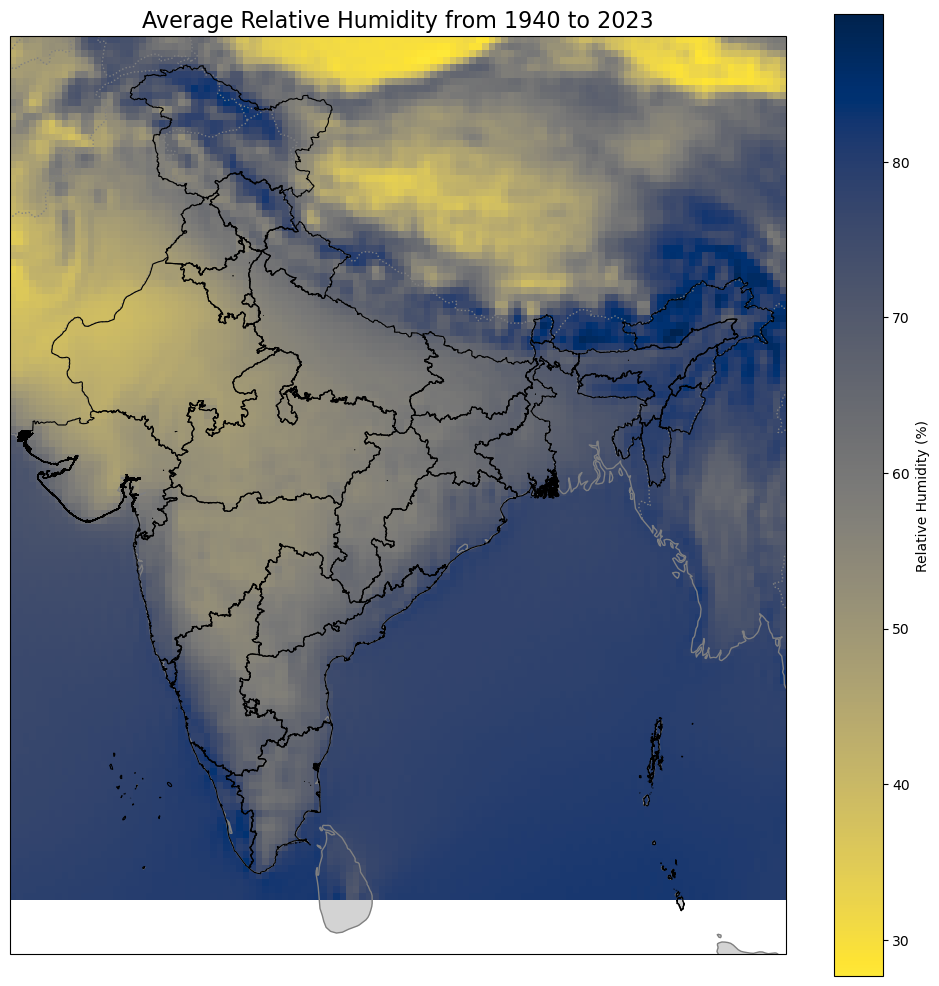

In [20]:
# Plotting the average relative humidity all on the map of India
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Add Indian states boundaries
Indian_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

# Plot the data
img = ax.pcolormesh(RH_3h_100['longitude'], RH_3h_100['latitude'], RH_3h_100['r'].sel(time=slice('1940-01-01', '2023-12-31')).mean(dim='time'), # year - month - day & mean of this period
                    cmap='cividis_r', transform=ccrs.PlateCarree())
cbar = plt.colorbar(img, ax=ax, label='Relative Humidity (%)')
#cbar.set_ticks([0, 20, 40, 60, 80, 100])

# Title and labels
plt.title("Average Relative Humidity from 1940 to 2023", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Function to create a mask for India
def create_india_mask(lon, lat, shapefile):
    """
    Create a mask for India based on the shapefile.
    """
    # Create a grid of points from longitude and latitude
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    points = [Point(lon, lat) for lon, lat in zip(lon_grid.ravel(), lat_grid.ravel())]

    # Check if each point is within India
    mask = np.array([shapefile.contains(point).any() for point in points])
    mask = mask.reshape(lon_grid.shape)  # Reshape to match the grid
    return mask

# Get longitude and latitude from the dataset
lon = RH_3h_100['longitude'].values
lat = RH_3h_100['latitude'].values

# Create the India mask
india_mask = create_india_mask(lon, lat, Indian_states)

# Apply the mask to the dataset
RH_masked_100 = RH_3h_100.copy()  # Create a copy of the dataset to avoid modifying the original
for var in RH_masked_100.data_vars:  # Loop through all variables in the dataset
    # Broadcast the mask to match the shape of the variable (time, lat, lon)
    broadcasted_mask = np.broadcast_to(india_mask[np.newaxis, :, :], RH_masked_100[var].shape)
    # Apply the mask
    RH_masked_100[var].values = np.where(broadcasted_mask, RH_masked_100[var].values, np.nan)

# Now RH_masked contains only values within Indian states
print(RH_masked_100)

<xarray.Dataset>
Dimensions:    (time: 245448, latitude: 124, longitude: 120)
Coordinates:
  * time       (time) datetime64[ns] 1940-01-01 ... 2023-12-31T21:00:00
  * longitude  (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude   (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25
Data variables:
    r          (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Oct 17 21:23:40 2024: cdo -b F32 mergetime 1940_India_R...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...


In [57]:
RH_masked_100['r'].max()

<xarray.DataArray 'r' ()>
array(99.99999237)

In [58]:
RH_masked_100['r'].min()

<xarray.DataArray 'r' ()>
array(8.29696655e-05)

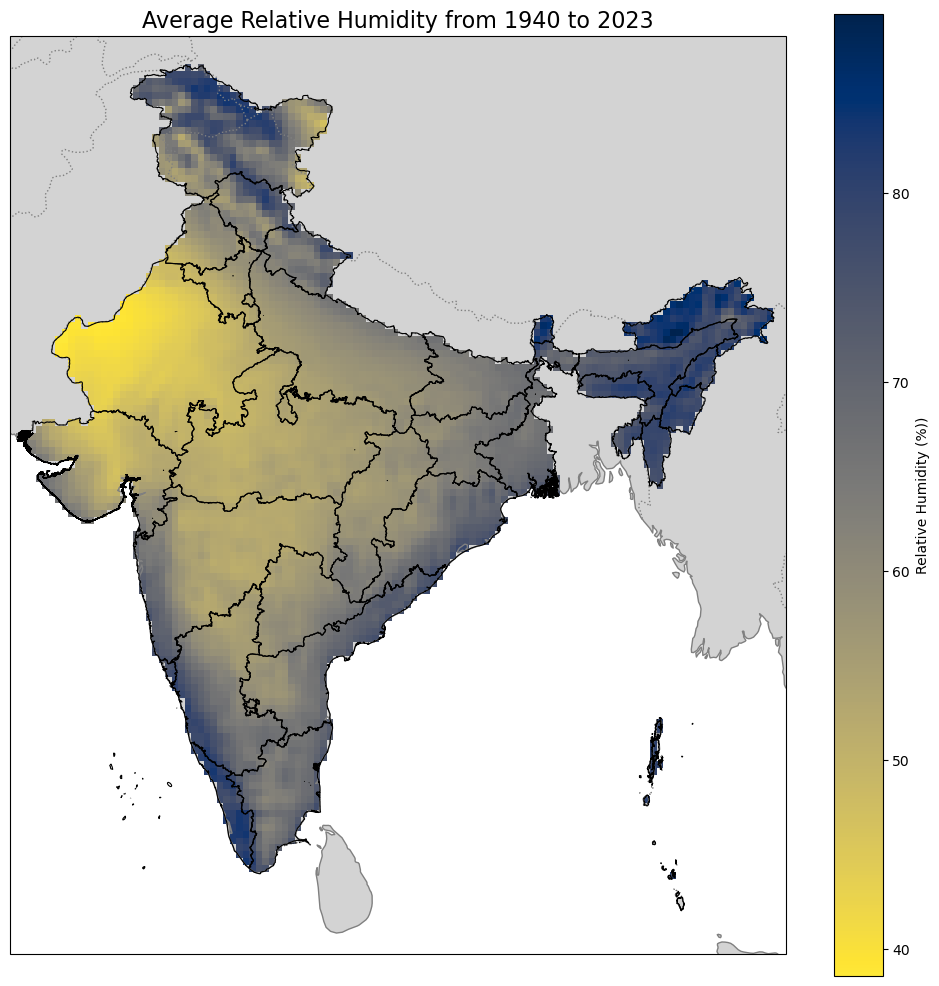

In [19]:
# Plotting the average relative humidity on the map of India
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Add Indian states boundaries
Indian_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

# Plot the data
img = ax.pcolormesh(RH_masked_100['longitude'], RH_masked_100['latitude'], RH_masked_100['r'].sel(time=slice('1940-01-01', '2023-12-31')).mean(dim='time'), # year - month - day & mean of this period
                    cmap='cividis_r', transform=ccrs.PlateCarree())
cbar = plt.colorbar(img, ax=ax, label='Relative Humidity (%))')

# Title and labels
plt.title("Average Relative Humidity from 1940 to 2023", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.tight_layout()
plt.show()

In [61]:
outputfile = "India_RH_3h_masked_100.nc"
RH_masked_100.to_netcdf(outputfile)

---
1.3. - Daily statistics min, max, avg for India

1.3.1- Daily stat 2m temperature 

In [15]:
# table for Temperature °C
file_T_3h = "India_T_3h_masked_C.nc"
T_3h = xr.open_dataset(file_T_3h)
T_3h['t2m']

<xarray.DataArray 't2m' (time: 245448, latitude: 124, longitude: 120)>
[3652266240 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1940-01-01 ... 2023-12-31T21:00:00
  * longitude  (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude   (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25

In [16]:
T_3h.max().values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 52.0>

In [17]:
T_3h.min().values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 -52.78>

In [5]:
# Compute daily maximum temperature
daily_max = T_3h['t2m'].resample(time='1D').max()

# Compute daily minimum temperature
daily_min = T_3h['t2m'].resample(time='1D').min()

# Compute daily average temperature
daily_avg = T_3h['t2m'].resample(time='1D').mean()

# Combine all three datasets into a new xarray.Dataset
daily_temp_stats = xr.Dataset(
    {
        'daily_max_temp': daily_max,
        'daily_min_temp': daily_min,
        'daily_avg_temp': daily_avg
    }
)

# Save the combined dataset to a new NetCDF file
output_file_1 = "India_T_daily_stats.nc"
daily_temp_stats.to_netcdf(output_file_1)

print(f"Daily maximum, minimum, and average temperatures have been saved to {output_file_1}")


Daily maximum, minimum, and average temperatures have been saved to India_T_daily_stats.nc


1.3.2 - Min and max of each day for relative humidity data

In [5]:
# table for % relative humidity 
file_RH_3h = "India_RH_3h_masked_100.nc"
RH_3h = xr.open_dataset(file_RH_3h)
RH_3h['r']

<xarray.DataArray 'r' (time: 245448, latitude: 124, longitude: 120)>
[3652266240 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1940-01-01 ... 2023-12-31T21:00:00
  * longitude  (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude   (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25
Attributes:
    standard_name:  relative_humidity
    long_name:      Relative humidity
    units:          %

In [ ]:
# Compute daily maximum RH
daily_max = RH_3h['r'].resample(time='1D').max()

# Compute daily minimum RH
daily_min = RH_3h['r'].resample(time='1D').min()

# Compute daily average RH
daily_avg = RH_3h['r'].resample(time='1D').mean()

# Combine all three datasets into a new xarray.Dataset
daily_RH_stats = xr.Dataset(
    {
        'daily_max_RH': daily_max,
        'daily_min_RH': daily_min,
        'daily_avg_RH': daily_avg
    }
)

# Save the combined dataset to a new NetCDF file
output_file_2 = "India_RH_daily_stats.nc"
daily_RH_stats.to_netcdf(output_file_2)

print(f"Daily maximum, minimum, and average relative humidity have been saved to {output_file_2}")


Daily maximum, minimum, and average relative humidity have been saved to India_RH_daily_stats.nc


---
1.4 - Data Representation

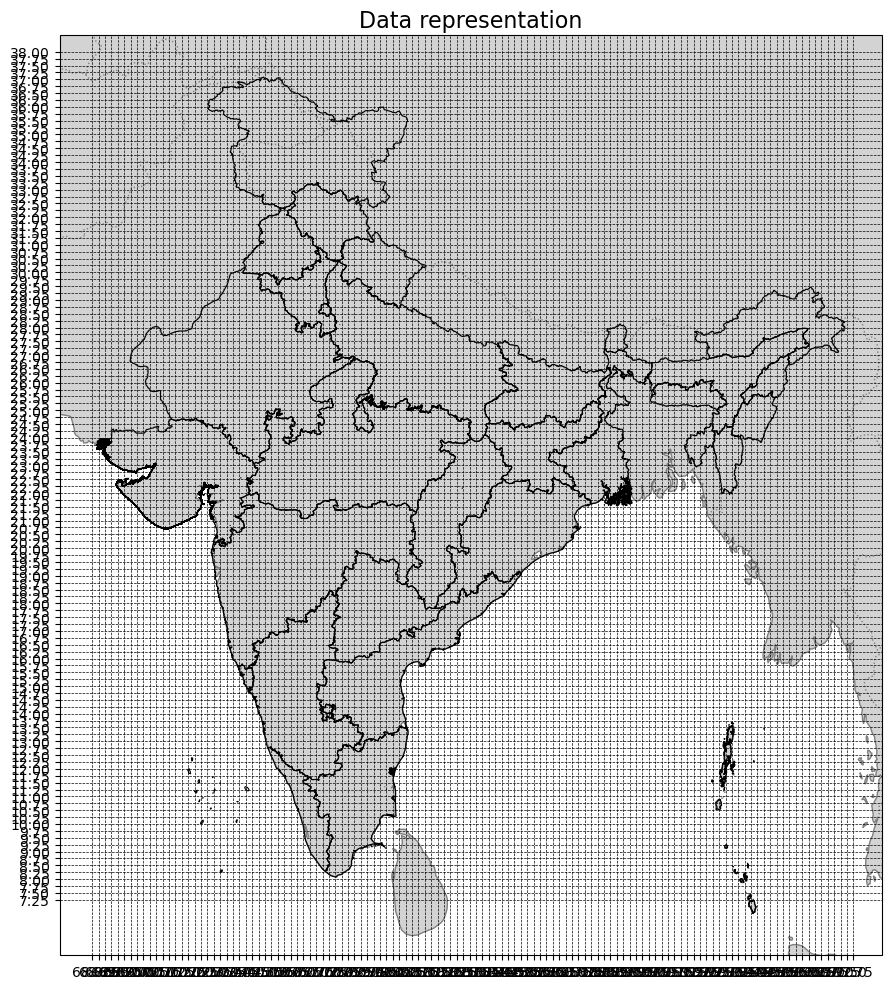

In [ ]:
# Create the map of India
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.COASTLINE, edgecolor="gray")
ax.add_feature(cfeature.LAND, facecolor="lightgray")

# Add Indian state boundaries
Indian_states.boundary.plot(ax=ax, edgecolor="black", linewidth=0.8)

# Define grid resolution 
lon = RH_masked_100["longitude"]
lat = RH_masked_100["latitude"]

# Add grid lines
ax.set_xticks(lon.values, crs=ccrs.PlateCarree())  # Set longitude grid
ax.set_yticks(lat.values, crs=ccrs.PlateCarree())  # Set latitude grid
ax.grid(visible=True, color="black", linestyle="--", linewidth=0.5)

# Title and labels
plt.title("Data representation", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.tight_layout()
plt.show()